# Линейная регрессия

In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Постановка

По 1260 опрошенным имеются следующие данные:

* заработная плата за час работы, $;
* опыт работы, лет;
* образование, лет;
* внешняя привлекательность, в баллах от 1 до 5;
* бинарные признаки: пол, семейное положение, состояние здоровья (хорошее/плохое), членство в профсоюзе, цвет кожи (белый/чёрный), занятость в сфере обслуживания (да/нет).

Требуется оценить влияние внешней привлекательности на уровень заработка с учётом всех остальных факторов.

Hamermesh D.S., Biddle J.E. (1994) Beauty and the Labor Market, American Economic Review, 84, 1174–1194.

Данные:

In [3]:
raw = pd.read_csv("beauty.csv", sep=";", index_col=False) 
raw.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


Посмотрим на матрицу диаграмм рассеяния по количественным признакам:

In [4]:
from pandas.tools.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000001784B0F6A0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000017883B99B0>]], dtype=object)

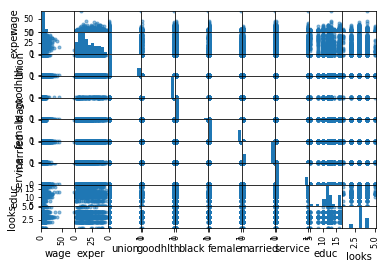

In [5]:
# Your code
scatter_matrix(raw)

Оценим сбалансированность выборки по категориальным признакам:

In [6]:
# Your code
raw.black.value_counts()

0    1167
1      93
Name: black, dtype: int64

In [7]:
raw.union.value_counts()

0    917
1    343
Name: union, dtype: int64

In [8]:
raw.goodhlth.value_counts()

1    1176
0      84
Name: goodhlth, dtype: int64

undersampling && oversampling

У каждого признака все значения встречаются достаточно много раз, так что всё в порядке.

## Предобработка

In [14]:
data = raw[raw["wage"]<70]

Посмотрим на распределение целевого признака — уровня заработной платы и его логарифма: 

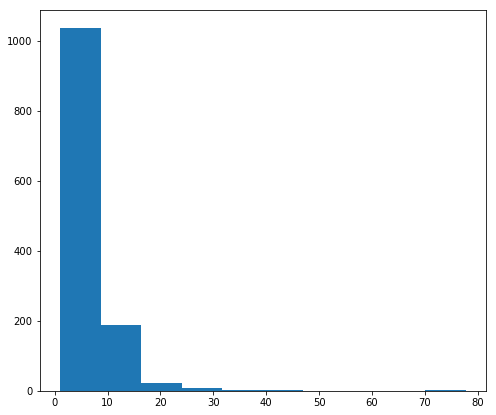

In [15]:
# Your code
plt.hist(raw['wage'])
plt.show()

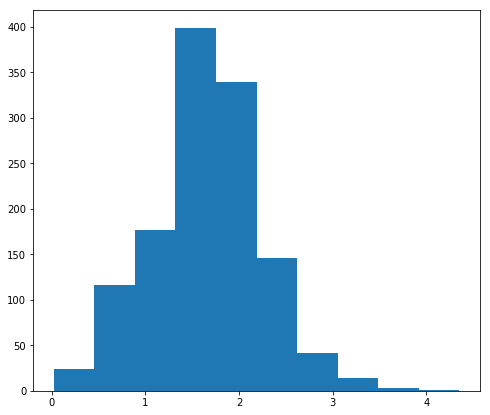

In [16]:
plt.hist(np.log(raw['wage']))
plt.show()

Один человек в выборке получает 77.72\$ в час, остальные — меньше 45\$; удалим этого человека, чтобы регрессия на него не перенастроилась.

In [17]:
# Your code

Посмотрим на распределение оценок привлекательности: 

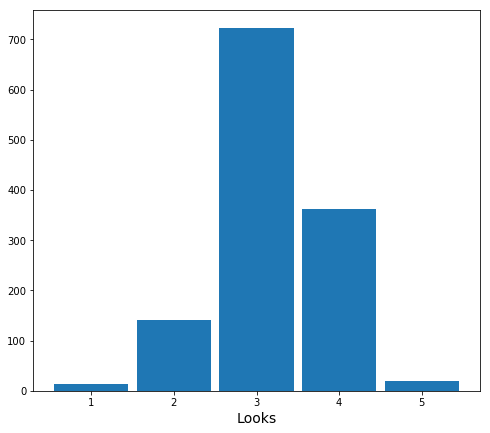

In [18]:
plt.figure(figsize(8,7))
data.groupby('looks')['looks'].agg(lambda x: len(x)).plot(kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.xlabel('Looks', fontsize=14)
pylab.show()

В группах looks=1 и looks=5 слишком мало наблюдений. Превратим признак looks в категориальный и закодируем с помощью фиктивных переменных:

In [25]:
# Your code
data["pretty"] = data["looks"].apply(lambda x: 1 if x>3 else 0)
data["ugly"] = data["looks"].apply(lambda x: 0 if x>3 else 1)
data = data.drop(["looks"],axis=1)

C:\Users\akrazer\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\akrazer\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Данные теперь:

In [26]:
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,pretty,ugly
0,5.73,30,0,1,0,1,1,1,14,1,0
1,4.28,28,0,1,0,1,1,0,12,0,1
2,7.96,35,0,1,0,1,0,0,10,1,0
3,11.57,38,0,1,0,0,1,1,16,0,1
4,11.42,27,0,1,0,0,1,0,16,0,1


## Построение модели

### Простейшая модель

Построим линейную модель по всем признакам.

In [27]:
m1 = smf.ols('wage ~ exper + union + goodhlth + black + female + married +'\
                    'service + educ + ugly + pretty', 
             data=data)
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     48.31
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           4.56e-75
Time:                        12:44:40   Log-Likelihood:                -3406.2
No. Observations:                1259   AIC:                             6832.
Df Residuals:                    1249   BIC:                             6884.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5303      0.495     -1.071      0.2

Посмотрим на распределение остатков (Q-Q график и гистграмма):

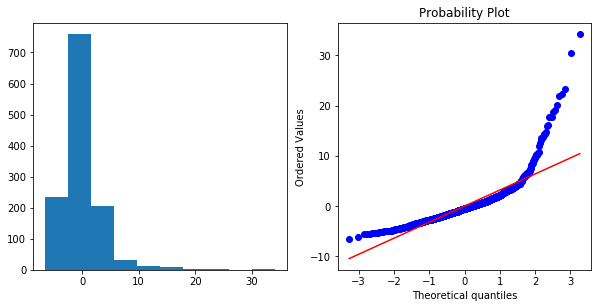

In [34]:
# Your code
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(fitted.resid)

plt.subplot(2,2,2)
sc.stats.probplot(fitted.resid,plot = plt)
plt.show()

### Логарифмируем отклик (целевую переменную)

In [36]:
m2 = smf.ols('np.log(wage) ~ exper + union + goodhlth + black + female + married +'\
                            'service + educ + ugly + pretty', data=data)
fitted = m2.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     84.55
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          1.64e-122
Time:                        12:52:47   Log-Likelihood:                -821.88
No. Observations:                1259   AIC:                             1664.
Df Residuals:                    1249   BIC:                             1715.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2817      0.064      4.432      0.0

Посмотрим на распределение остатков (Q-Q график и гистограмма)

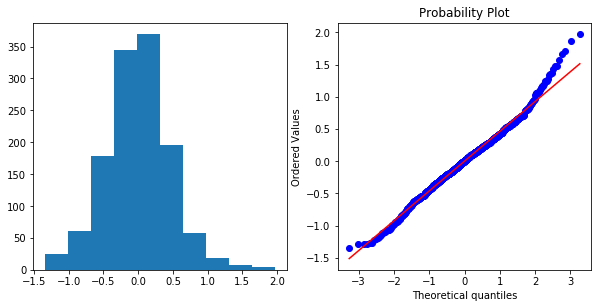

In [37]:
# Your code
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(fitted.resid)

plt.subplot(2,2,2)
sc.stats.probplot(fitted.resid,plot = plt)
plt.show()

Посмотрим теперь на зависимость остатков от непрерывных признаков:

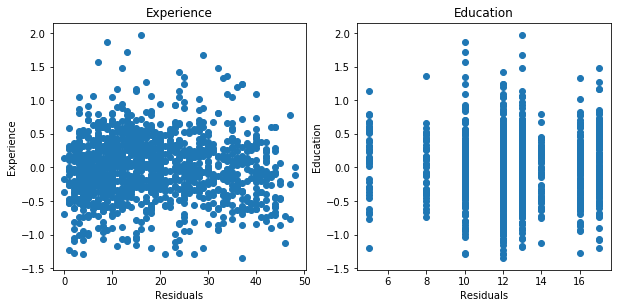

In [43]:
# Your code
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Experience")
plt.scatter(data.exper,fitted.resid)
plt.xlabel("Residuals")
plt.ylabel("Experience")

plt.subplot(2,2,2)
plt.title("Education")
plt.scatter(data.educ,fitted.resid)
plt.xlabel("Residuals")
plt.ylabel("Education")

plt.show()

### Добавляем квадрат опыта работы

In [63]:
m3 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + goodhlth + black + female +'\
                            'married + service + educ + ugly + pretty', data=data)
fitted = m3.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     82.35
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          7.61e-130
Time:                        13:12:52   Log-Likelihood:                -802.38
No. Observations:                1259   AIC:                             1627.
Df Residuals:                    1248   BIC:                             1683.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2095      0

Посмотрим на распределение остатков (Q-Q график и гистограмма) и их зависимость от непрерывных признаков

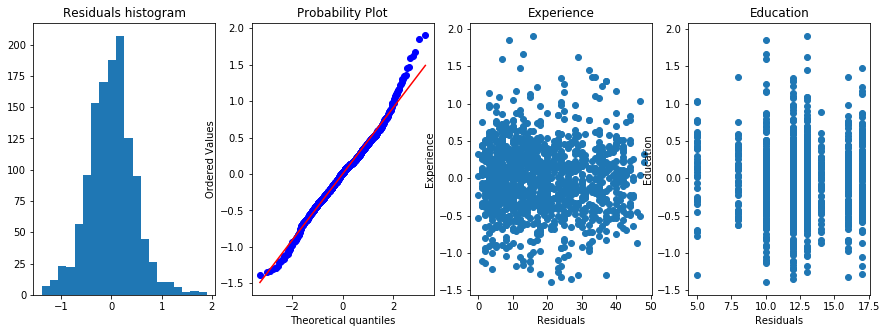

In [51]:
# Your code
fig = plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.title("Residuals histogram")
plt.hist(fitted.resid,bins=20)

plt.subplot(1,4,2)
plt.title("Q-Q plot")
sc.stats.probplot(fitted.resid,plot = plt)

plt.subplot(1,4,3)
plt.title("Experience")
plt.scatter(data.exper,fitted.resid)
plt.xlabel("Residuals")
plt.ylabel("Experience")

plt.subplot(1,4,4)
plt.title("Education")
plt.scatter(data.educ,fitted.resid)
plt.xlabel("Residuals")
plt.ylabel("Education")

plt.show()

Используем критерий Бройша-Пагана для проверки гомоскедастичности ошибок:

In [64]:
print('Breusch-Pagan test: p=%f' % sms.het_breushpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000005


Какие выводы? ЧТо нужно попробовать сделать?

### Удаляем незначимые признаки

In [ ]:
!conda update statsmodels

In [75]:
# Your code of m4 regressor
m5 = smf.ols('np.log(wage) ~ exper + np.power(exper,2) + union + female'\
                            '+ service + educ + ugly + pretty', data=data)

Посмотрим, не стала ли модель от удаления признаков значимо хуже, с помощью критерия Фишера:

In [76]:
print("F=%f, p=%f, k1=%f" % m3.fit(cov_type = "HC1").compare_f_test(m5.fit()))

F=1.369930, p=0.250380, k1=3.000000


C:\Users\akrazer\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1746: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)


Проверим, нет ли наблюдений, которые слишком сильно влияют на регрессионное уравнение:

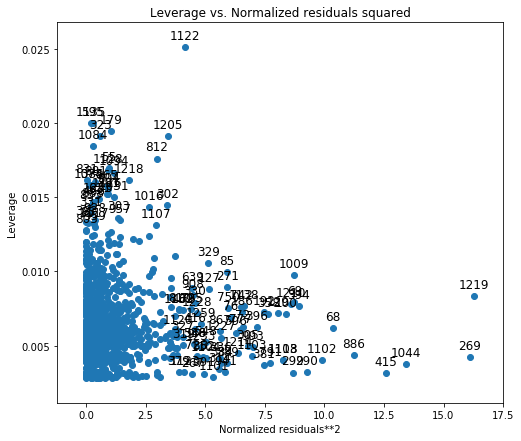

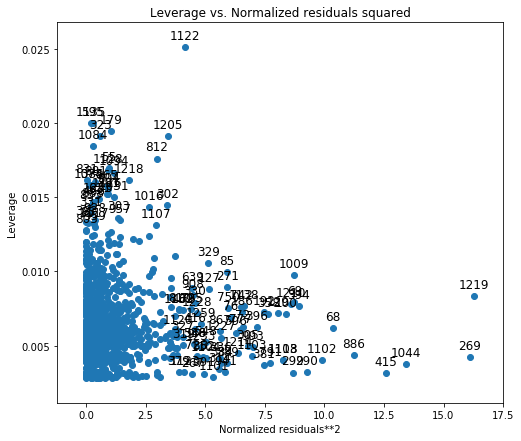

In [77]:
# Your code
fitted_m5 = m5.fit()
plot_leverage_resid2(fitted_m5)

In [78]:
fitted_m5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     117.0
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          5.04e-132
Time:                        13:17:06   Log-Likelihood:                -804.45
No. Observations:                1259   AIC:                             1625.
Df Residuals:                    1251   BIC:                             1666.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2431      0.053      4.601      0.000       0.139       0.347
exper                  0.0408      0.004      9.570      0.000       0.032       0.049
np.power(exper, 2)    -0.0006   9.52e-05     -6.561      0.000      -0.001      -0.000
union                  0.1748      0.030      5.907      0.000       0.117       0.233
female                -0.4062      0.029    -13.782      0.000      -0.464      -0.348
service               -0.1642      0.032     -5.144      0.000      -0.227      -0.102
educ                   0.0786      0.005     14.608      0.000       0.068       0.089
ugly                   0.1107      0.029      3.856      0.000       0.054       0.167
pretty                 0.1324      0.031      4.215      0.000       0.071       0.194
==============================================================================
Omnibus:                       26.231   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.479
Skew:                           0.131   Prob(JB):                     8.08e-11
Kurtosis:                       3.904   Cond. No.                     3.60e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.98e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Выводы